# Property insurance risk assessment: 
using public data to estimate building features that affect insurance value


In [225]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, MaxPool2D, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


## Part 1: Self-constructed CNN model

### Define the constant

In [226]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Remove the duplicate images

In [227]:
# hashes = set()
# directory = "../uni_project_data/uni_project_data/street_view_juny12"

# for filename in os.listdir("../uni_project_data/uni_project_data/street_view_juny12"):
#     path = os.path.join(directory, filename)
#     digest = hashlib.sha1(open(path,'rb').read()).digest()
#     if digest not in hashes:
#         hashes.add(digest)
#     else:
#         os.remove(path)

#### randomly pick the training/validation/test set

In [228]:
# load the property information
pro = pd.read_csv("../uni_project_data/uni_project_data/properties_juny12.csv")
pro['property_id'] = 'gsv_' + pro['property_id'] + '.jpg'
pro.head()

,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"Lynton, Grove Park, Pontnewydd, Cwmbran, Torfa...",Detached,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.66695,-3.02439,gsv_7ef3b02b-f9bf-4841-9acf-418ef77f61d4.jpg
1,0,"33, Mynydd Maen Road, Pontnewydd, Cwmbran, Tor...",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.66475,-3.03967,gsv_176edf8e-c0d2-4207-9293-c38f933f0cde.jpg
2,0,"18, Llanyravon Square, Llanyravon, Cwmbran, To...",Flat,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.64579,-3.00715,gsv_79b65e2f-c3ba-445f-ac72-f2e7521e234f.jpg
3,0,"9, Pontnewydd Walk, Cwmbran, Torfaen NP44 1PY",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.65582,-3.02182,gsv_d954e969-602c-43fd-8768-da110a2a6985.jpg
4,0,"56, Mynydd Maen Road, Pontnewydd, Cwmbran, Tor...",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.66518,-3.04098,gsv_a57563ab-ffce-4f74-a14a-cc18d7fb57dc.jpg


In [229]:
# # select 5000 samples as training set 
# def moveFile_train(op, np):
#     filenames = os.listdir("../uni_project_data/uni_project_data/street_view_juny12")
#     trainingset = random.sample(filenames, 5000) 
#     for i in trainingset:
#         # copy the training file to another path
#         shutil.copyfile(os.path.join(op,i), os.path.join(np,i))
#     return

# path = '../uni_project_data/uni_project_data/sample5000'
# if not os.path.exists(path):
#     os.mkdir(path)

# if __name__ == '__main__':
#     src = r'../uni_project_data/uni_project_data/street_view_juny12'
#     dst = r'../uni_project_data/uni_project_data/sample5000'
#     moveFile_train(src,dst)

In [230]:
filenames = os.listdir("../uni_project_data/uni_project_data/sample5000")
sample_df = pd.DataFrame({
    'property_id': filenames
})
sampledf = pro.merge(sample_df, on = 'property_id')
sampledf.head()


,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"33, Mynydd Maen Road, Pontnewydd, Cwmbran, Tor...",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.66475,-3.03967,gsv_176edf8e-c0d2-4207-9293-c38f933f0cde.jpg
1,0,"6, Steynton Path, Fairwater, Cwmbran, Torfaen ...",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,51.64594,-3.04111,gsv_d3a04dec-6569-4bf6-8101-9e6e442b5b97.jpg
2,0,"16, Ynys Lane, Croesyceiliog, Cwmbran, Torfaen...",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.66176,-3.01054,gsv_6fe10950-4b55-434b-8ee1-52416ab82bd6.jpg
3,0,"7, Smallbrook Close, Cwmbran, Torfaen NP44 3QA",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.64972,-3.01981,gsv_0970de06-fb7c-4893-87db-2ac9f88433a5.jpg
4,0,"17, Dunraven Road, Llanyravon, Cwmbran, Torfae...",Semi-Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.64895,-3.00476,gsv_015b2b16-7dae-475f-bb40-156d817b1175.jpg


In [231]:
# detached = sampledf.loc[sampledf.propertyType == 'Detached', 'property_id']
# detached.tolist()

# path = '../uni_project_data/uni_project_data/detached'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in detached:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/detached',i))
        

# semi_detached = sampledf.loc[sampledf.propertyType == 'Semi-Detached', 'property_id']
# semi_detached.tolist()

# path = '../uni_project_data/uni_project_data/semi_detached'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in semi_detached:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/semi_detached',i))

# unknown = sampledf.loc[sampledf.propertyType == 'Unknown', 'property_id']
# unknown.tolist()

# path = '../uni_project_data/uni_project_data/unknown'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in unknown:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/unknown',i))


# Terraced = sampledf.loc[sampledf.propertyType == 'Terraced', 'property_id']
# Terraced.tolist()

# path = '../uni_project_data/uni_project_data/Terraced'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in Terraced:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/Terraced',i))


# Flat = sampledf.loc[sampledf.propertyType == 'Flat', 'property_id']
# Flat.tolist()

# path = '../uni_project_data/uni_project_data/Flat'
# if not os.path.exists(path):
#     os.mkdir(path)

# for i in Flat:
#         shutil.copyfile(os.path.join("../uni_project_data/uni_project_data/samplenew",i), os.path.join('../uni_project_data/uni_project_data/Flat',i))


<AxesSubplot:>

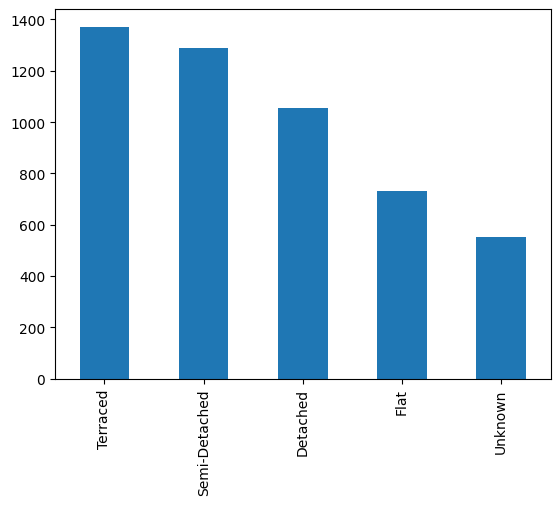

In [232]:
sampledf['propertyType'].value_counts().plot.bar()

In [233]:
# sample = random.choice(filenames)
# image = load_img("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/"+sample)
# plt.imshow(image)

### Spliting the train and test set

In [234]:
train, validation = train_test_split(sampledf, test_size=0.1, random_state=66)
train, test = train_test_split(train, test_size=1/9, random_state=66)
train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)
test = test.reset_index(drop=True)

In [235]:
train_num = train.shape[0]
validation_num = validation.shape[0]
batch_size=64
epochs=50

### Building CNN model

In [236]:
model = Sequential()

# Convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 318, 318, 64)      1792      
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 159, 159, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 157, 157, 128)     73856     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 78, 78, 128)      0         
 g2D)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 78, 78, 128)       0         
                                                                 
 conv2d_80 (Conv2D)          (None, 76, 76, 256)     

### Prevent over-fitting: callback

In [237]:
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

In [238]:
# We will reduce the learning rate when then accuracy not increase for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

In [239]:
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop]

### Image generator

In [240]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    # # horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4000 validated image filenames belonging to 5 classes.


In [241]:
validation_idg = ImageDataGenerator(rescale=1./255)
validation_imagegenerator = validation_idg.flow_from_dataframe(
    validation, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 5 classes.


In [242]:
# # example: 

# example_df = train.sample(n=1).reset_index(drop=True)
# example_generator = train_idg.flow_from_dataframe(
#     example_df, 
#     "../uni_project_data/uni_project_data/sample5000/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [243]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

### Fit on the Training set and make predcitons on the Validation set

In [244]:

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=validation_imagegenerator,
    validation_steps=validation_num//batch_size,
    steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)




Epoch 1/50
62/62 [==============================] - 566s 9s/step - loss: 1.7512 - accuracy: 0.2650 - val_loss: 1.5621 - val_accuracy: 0.2388 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 553s 9s/step - loss: 1.5499 - accuracy: 0.2774 - val_loss: 1.5076 - val_accuracy: 0.2768 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 551s 9s/step - loss: 1.5158 - accuracy: 0.3333 - val_loss: 1.4756 - val_accuracy: 0.3549 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 547s 9s/step - loss: 1.5013 - accuracy: 0.3443 - val_loss: 1.4960 - val_accuracy: 0.3192 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 556s 9s/step - loss: 1.4934 - accuracy: 0.3402 - val_loss: 1.4762 - val_accuracy: 0.3259 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - ETA: 0s - loss: 1.4757 - accuracy: 0.3572
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
62/62 [==============================] - 589s 9s/step - los

### Visualize the result

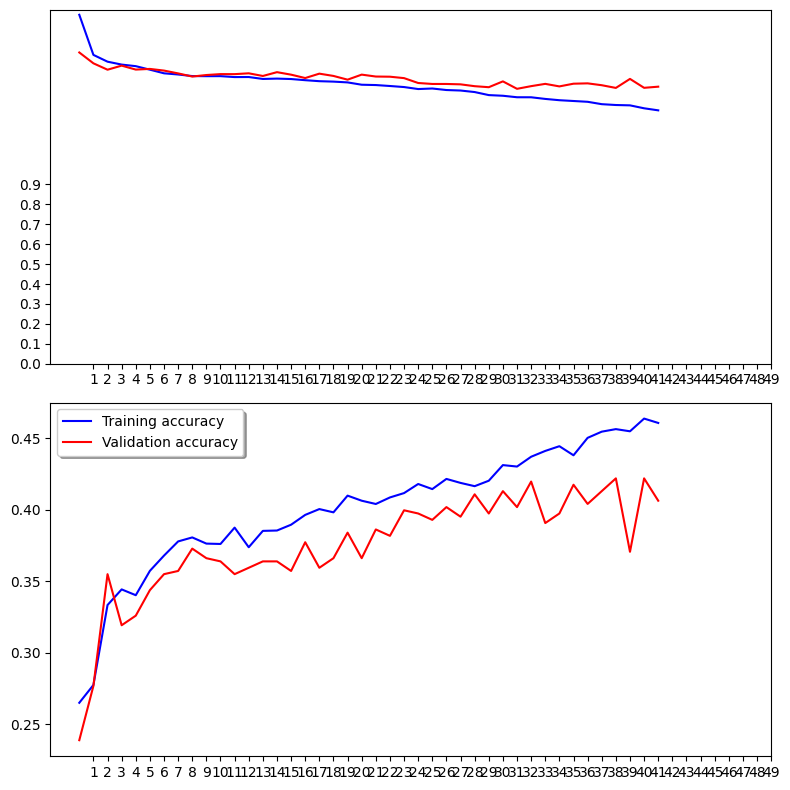

In [245]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

### prediction on test set

In [246]:
test_filenames = test['property_id']
test_df1 = pd.DataFrame({
    'property_id': test_filenames
})
nb_test = test_df1.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


In [247]:
# make predictions on test set
predict = model.predict_generator(test_generator, steps=np.ceil(nb_test/batch_size))
predict

array([[0.45450628, 0.15586746, 0.19664027, 0.14432804, 0.04865795],
       [0.02480909, 0.43081066, 0.02790866, 0.27730665, 0.23916504],
       [0.12553138, 0.1053111 , 0.47552353, 0.28635672, 0.00727722],
       ...,
       [0.5201062 , 0.08324173, 0.14719552, 0.13736317, 0.1120934 ],
       [0.02212826, 0.06502473, 0.0145527 , 0.85183555, 0.04645877],
       [0.09447838, 0.09645257, 0.21327229, 0.32239643, 0.2734003 ]],
      dtype=float32)

In [248]:
test_df1['type'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_imagegenerator.class_indices.items())
test_df1['type'] = test_df1['type'].replace(label_map)

In [249]:
test_df1

,property_id,type
0,gsv_a428649d-a8df-4243-a897-4cdbad72ac46.jpg,Detached
1,gsv_75cff80f-8ea1-4f83-8d7f-44fe9f98fb3b.jpg,Flat
2,gsv_5bee0ee5-72ce-445a-be44-886d7954f5f6.jpg,Semi-Detached
3,gsv_ab2ce1e0-a9f3-43cb-9657-d17f2df2f9cd.jpg,Semi-Detached
4,gsv_48d4b560-5af5-4332-945b-2f917be2fc72.jpg,Terraced
...,...,...
495,gsv_7eec0b21-b025-4976-96df-f7110aa8418c.jpg,Semi-Detached
496,gsv_08871cc6-e3e7-43b2-a272-0c932c2b858b.jpg,Detached
497,gsv_9dd0e9e8-e484-4a68-9801-4f951b9cad50.jpg,Detached
498,gsv_a3e94dfa-206a-41e9-9a59-0b92d61c6c90.jpg,Terraced


In [250]:
df_merged = pd.merge(test_df1, sampledf[['property_id', 'propertyType']], on='property_id', how='left')
df_merged

,property_id,type,propertyType
0,gsv_a428649d-a8df-4243-a897-4cdbad72ac46.jpg,Detached,Terraced
1,gsv_75cff80f-8ea1-4f83-8d7f-44fe9f98fb3b.jpg,Flat,Terraced
2,gsv_5bee0ee5-72ce-445a-be44-886d7954f5f6.jpg,Semi-Detached,Flat
3,gsv_ab2ce1e0-a9f3-43cb-9657-d17f2df2f9cd.jpg,Semi-Detached,Detached
4,gsv_48d4b560-5af5-4332-945b-2f917be2fc72.jpg,Terraced,Semi-Detached
...,...,...,...
495,gsv_7eec0b21-b025-4976-96df-f7110aa8418c.jpg,Semi-Detached,Semi-Detached
496,gsv_08871cc6-e3e7-43b2-a272-0c932c2b858b.jpg,Detached,Detached
497,gsv_9dd0e9e8-e484-4a68-9801-4f951b9cad50.jpg,Detached,Detached
498,gsv_a3e94dfa-206a-41e9-9a59-0b92d61c6c90.jpg,Terraced,Unknown


In [251]:
y_test = df_merged['propertyType']
y_pred = df_merged['type']
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[44 11 33 17  7]
 [ 6 29  8 21  5]
 [23  6 62 22 18]
 [14 11 35 62  9]
 [ 8  9  8  7 25]]


In [252]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.44



# Part 2: Image Pre-processing

#### try the methods of Edge detection and Image segmentation to enhance the characteristics of images. 

#### Edge detection

creat the edge image and save them in the 'sample_edge' folder

In [253]:
# sample = cv2.imread('../street_view/street_view/gsv_0071ec1b-84f7-4051-83a2-b6a9b9e8c7bd.jpg')
# grey_sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
# canny = cv2.Canny(grey_sample,30,150)
# cv2.imwrite("../street_view/street_edge/gsv_0071ec1b-84f7-4051-83a2-b6a9b9e8c7bd_noGau.jpg", canny)

In [254]:
# path = '../uni_project_data/uni_project_data/sample_edge5000'
# if not os.path.exists(path):
#     os.mkdir(path)


# # example of edge detection
# filenames = os.listdir("../uni_project_data/uni_project_data/sample5000")
# for file in filenames:
#     # read the image
#     sample = cv2.imread('../uni_project_data/uni_project_data/sample5000/' + file)
#     # turn RGB into grey image
#     grey_sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

#     # # show the grey image
#     # cv2.imshow("Grey Image",grey_sample)
#     # cv2.waitKey()
    
#     # Gaussian denoising filter
#     Gau_img = cv2.GaussianBlur(grey_sample, (7, 7), 1.5)
#     # Gau_img = cv2.GaussianBlur(grey_sample, (5, 5), 2)
#     # Gau_img = cv2.GaussianBlur(grey_sample, (5, 5), 1.5)


#     # # 使用Canny算法进行边缘检测
#     # edges = cv2.Canny(sample, threshold1, threshold2)

#     # # 显示边缘图像
#     # cv2.imshow('Edges', edges)
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()


#     #Canny edge detection
#     canny = cv2.Canny(Gau_img,30,150)
#     # cv2.imshow("Canny",canny)
#     # cv2.waitKey()

#     # save the edge img
#     cv2.imwrite("../uni_project_data/uni_project_data/sample_edge5000/" + file, canny)


#### combine the edge image CNN

In [255]:
withedge_df = pd.DataFrame(columns=['property_id','edge'])
withedge_df['property_id'] = sampledf['property_id']
df2 = pd.merge(withedge_df, sampledf[['property_id', 'propertyType']], on='property_id', how='left')
df2['edge'] = df2['property_id']
df2['property_id'] = '../uni_project_data/uni_project_data/sample5000/' + df2['property_id'] 
df2['edge'] = '../uni_project_data/uni_project_data/sample_edge5000/' + df2['edge'] 
df2

,property_id,edge,propertyType
0,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
1,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Semi-Detached
2,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
3,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
4,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Semi-Detached
...,...,...,...
4995,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Flat
4996,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Detached
4997,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Terraced
4998,../uni_project_data/uni_project_data/sample500...,../uni_project_data/uni_project_data/sample_ed...,Semi-Detached


In [256]:
from PIL import Image


train_df, val_df = train_test_split(df2, test_size=0.1, random_state=22)
train_df, test_df = train_test_split(train_df, test_size=1/9, random_state=22)

# custom data generator
class PairedImageDataGenerator:
    def __init__(self, dataframe, image_data_generator):
        self.dataframe = dataframe
        self.image_data_generator = image_data_generator
    
    def generate(self, batch_size=32, shuffle=True):
        indices = np.arange(len(self.dataframe))
        if shuffle:
            np.random.shuffle(indices)
        
        while True:
            for start in range(0, len(indices), batch_size):
                batch_indices = indices[start : start + batch_size]
                batch_df = self.dataframe.iloc[batch_indices]
                batch_original_images = []
                batch_edge_images = []
                batch_labels = []
                
                for _, row in batch_df.iterrows():
                    original_image = cv2.imread(row['property_id'], cv2.IMREAD_GRAYSCALE)
                    edge_image = cv2.imread(row['edge'], cv2.IMREAD_GRAYSCALE)
                    label = row['propertyType']
                    
                    batch_original_images.append(original_image)
                    batch_edge_images.append(edge_image)
                    batch_labels.append(label)
                
                
                batch_original_images = np.array(batch_original_images)
                batch_edge_images = np.array(batch_edge_images)
                batch_labels = np.array(batch_labels)
                
                # 归一化图像像素值
                batch_original_images = batch_original_images / 255.0
                batch_edge_images = batch_edge_images / 255.0
                
                # 将图像形状从 (height, width) 转换为 (height, width, channels)
                batch_original_images = np.expand_dims(batch_original_images, axis=-1)
                batch_edge_images = np.expand_dims(batch_edge_images, axis=-1)
                
                label_mapping = {'Terraced': 0, 'Detached': 1, 'Semi-Detached': 2, 'Flat': 3, 'Unknown': 4}
                batch_labels = [label_mapping[label] for label in batch_labels]
                batch_labels = tf.keras.utils.to_categorical(batch_labels, num_classes=5)
                
                yield [batch_original_images, batch_edge_images], batch_labels

# Create an ImageDataGenerator object for preprocessing images
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    # horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

validation_idg = ImageDataGenerator(rescale=1./255)


train_datagen = PairedImageDataGenerator(train_df, train_idg)
val_datagen = PairedImageDataGenerator(val_df, validation_idg)


train_generator = train_datagen.generate(batch_size=64)
val_generator = val_datagen.generate(batch_size=64)



In [257]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

# Define input layers
property_id = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1))
edge = Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 1))

# Shared convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')
maxpool1 = MaxPooling2D()
conv2 = Conv2D(64, (2, 2), activation='relu')
maxpool2 = MaxPooling2D()
conv3 = Conv2D(128, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.01))
maxpool3 = MaxPooling2D()
# conv4 = Conv2D(256, (2, 2), activation='relu')
# maxpool4 = MaxPooling2D()

# Original image branch
x1 = conv1(property_id)
x1 = maxpool1(x1)
x1 = Dropout(0.25)(x1)
x1 = conv2(x1)
x1 = maxpool2(x1)
x1 = Dropout(0.25)(x1)
x1 = conv3(x1)
x1 = maxpool3(x1)
x1 = Dropout(0.25)(x1)
# x1 = conv4(x1)
# x1 = maxpool4(x1)
# x1 = Dropout(0.25)(x1)
x1 = Flatten()(x1)

# Edge detection image branch
x2 = conv1(edge)
x2 = maxpool1(x2)
x2 = conv2(x2)
x2 = maxpool2(x2)
x2 = Dropout(0.25)(x2)
x2 = conv3(x2)
x2 = maxpool3(x2)
x2 = Dropout(0.25)(x2)
# x2 = conv4(x2)
# x2 = maxpool4(x2)
# x2 = Dropout(0.25)(x2)
x2 = Flatten()(x2)

# Concatenate the outputs of both branches
combined = concatenate([x1, x2])

# Fully connected layers
fc1 = Dense(512, activation='relu')
# fc2 = Dense(256, activation='relu')
fc3 = Dense(64, activation='relu')
output = Dense(5, activation='softmax')

# Connect the layers and create the model
x = fc1(combined)
# x = fc2(x)
x = fc3(x)
propertyType = output(x)

model2 = Model(inputs=[property_id, edge], outputs=propertyType)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 320, 320, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_82 (Conv2D)             (None, 318, 318, 32  320         ['input_5[0][0]',                
                                )                                 'input_6[0][0]']                
                                                                                                  
 input_6 (InputLayer)           [(None, 320, 320, 1  0           []                               
                                )]                                                          

In [258]:
history2 = model2.fit(train_generator, validation_data=val_generator, 
          steps_per_epoch = 4000 // 64,
          validation_steps = 500 // 64, 
          epochs=20)

Epoch 1/20
62/62 [==============================] - 441s 7s/step - loss: 3.5172 - accuracy: 0.2855 - val_loss: 2.1267 - val_accuracy: 0.3504
Epoch 2/20
62/62 [==============================] - 427s 7s/step - loss: 2.0360 - accuracy: 0.3476 - val_loss: 1.9823 - val_accuracy: 0.3214
Epoch 3/20
62/62 [==============================] - 423s 7s/step - loss: 1.8744 - accuracy: 0.3791 - val_loss: 1.9026 - val_accuracy: 0.3259
Epoch 4/20
62/62 [==============================] - 418s 7s/step - loss: 1.7078 - accuracy: 0.4418 - val_loss: 1.8446 - val_accuracy: 0.3393
Epoch 5/20
62/62 [==============================] - 414s 7s/step - loss: 1.4596 - accuracy: 0.5490 - val_loss: 1.9027 - val_accuracy: 0.3080
Epoch 6/20
62/62 [==============================] - 414s 7s/step - loss: 1.1426 - accuracy: 0.6763 - val_loss: 2.0908 - val_accuracy: 0.3125
Epoch 7/20
62/62 [==============================] - 422s 7s/step - loss: 0.9481 - accuracy: 0.7358 - val_loss: 2.3500 - val_accuracy: 0.2812
Epoch 8/20
62

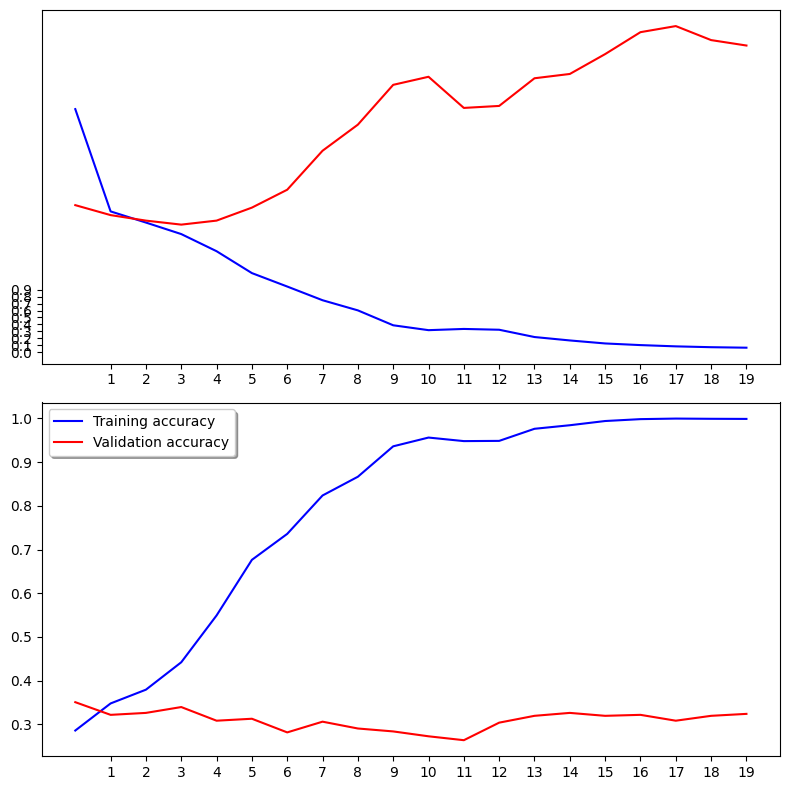

In [259]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history2.history['loss'], color='b', label="Training loss")
ax1.plot(history2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 20, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 20, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

predict the result

In [260]:
# test generator

class TestImageDataGenerator:
    def __init__(self, dataframe):
        self.dataframe = dataframe
    
    def generate(self, batch_size=32):
        indices = np.arange(len(self.dataframe))
        
        while True:
            for start in range(0, len(indices), batch_size):
                batch_indices = indices[start: start + batch_size]
                batch_df = self.dataframe.iloc[batch_indices]
                batch_original_images = []
                batch_edge_images = []
                
                for _, row in batch_df.iterrows():
                    original_image = cv2.imread(row['property_id'], cv2.IMREAD_GRAYSCALE)
                    edge_image = cv2.imread(row['edge'], cv2.IMREAD_GRAYSCALE)
                    
                    batch_original_images.append(original_image)
                    batch_edge_images.append(edge_image)
                
                batch_original_images = np.array(batch_original_images)
                batch_edge_images = np.array(batch_edge_images)
                
                batch_original_images = batch_original_images / 255.0
                batch_edge_images = batch_edge_images / 255.0
                
                batch_original_images = np.expand_dims(batch_original_images, axis=-1)
                batch_edge_images = np.expand_dims(batch_edge_images, axis=-1)
                
                yield [batch_original_images, batch_edge_images]


test_datagen = TestImageDataGenerator(test_df)
test_generator = test_datagen.generate(batch_size=1)


In [261]:
test_filenames = test_df['property_id']
test_df2 = pd.DataFrame({
    'property_id': test_filenames
})

nb_test = test_df2.shape[0]
test_df2



,property_id
1065,../uni_project_data/uni_project_data/sample500...
4146,../uni_project_data/uni_project_data/sample500...
2571,../uni_project_data/uni_project_data/sample500...
3210,../uni_project_data/uni_project_data/sample500...
4950,../uni_project_data/uni_project_data/sample500...
...,...
2421,../uni_project_data/uni_project_data/sample500...
4957,../uni_project_data/uni_project_data/sample500...
4358,../uni_project_data/uni_project_data/sample500...
945,../uni_project_data/uni_project_data/sample500...


In [262]:
# predict2 = model2.predict_generator(test_generator, steps=np.ceil(nb_test/64))
predictions = []
for _ in range(nb_test):
    batch_images = next(test_generator)
    original_image = batch_images[0]
    edge_image = batch_images[1]
    prediction = model2.predict([original_image, edge_image])
    predictions.append(prediction)

predictions = np.concatenate(predictions, axis=0)
predictions

1/1 [==============================] - 0s 77ms/step


array([[4.7539151e-01, 1.3025703e-03, 5.1771057e-01, 3.6051605e-04,
        5.2349078e-03],
       [7.7998257e-01, 2.1774299e-01, 2.8284476e-04, 1.8799021e-03,
        1.1170304e-04],
       [2.6961735e-03, 1.0758510e-03, 9.9517608e-01, 8.4022089e-04,
        2.1169604e-04],
       ...,
       [4.5706365e-01, 3.8184130e-01, 1.3502327e-01, 1.0832509e-03,
        2.4988459e-02],
       [6.6983961e-03, 4.0028843e-01, 1.3222607e-04, 5.9285927e-01,
        2.1689952e-05],
       [2.5307055e-04, 4.9006403e-04, 9.9877340e-01, 9.3557202e-07,
        4.8248997e-04]], dtype=float32)

In [263]:
test_df2['type'] = np.argmax(predictions, axis=-1)


label_mapping = {0: 'Terraced', 1: 'Detached', 2: 'Semi-Detached', 3: 'Flat', 4: 'Unknown'}
test_df2['type'] = np.argmax(predictions, axis=-1)
test_df2['type'] = test_df2['type'].replace(label_mapping)

df_merged_edge = pd.merge(test_df2, df2[['property_id', 'propertyType']], on='property_id', how='left')
df_merged_edge


,property_id,type,propertyType
0,../uni_project_data/uni_project_data/sample500...,Semi-Detached,Semi-Detached
1,../uni_project_data/uni_project_data/sample500...,Terraced,Terraced
2,../uni_project_data/uni_project_data/sample500...,Semi-Detached,Detached
3,../uni_project_data/uni_project_data/sample500...,Terraced,Semi-Detached
4,../uni_project_data/uni_project_data/sample500...,Terraced,Detached
...,...,...,...
495,../uni_project_data/uni_project_data/sample500...,Detached,Semi-Detached
496,../uni_project_data/uni_project_data/sample500...,Detached,Detached
497,../uni_project_data/uni_project_data/sample500...,Terraced,Terraced
498,../uni_project_data/uni_project_data/sample500...,Flat,Unknown


In [264]:
y_test2 = df_merged_edge['propertyType']
y_pred2 = df_merged_edge['type']
confusion2 = confusion_matrix(y_test2, y_pred2)
print('Confusion Matrix\n')
print(confusion2)

Confusion Matrix

[[35 12 16 31 13]
 [ 6 17  7 21  3]
 [32  8 49 32  7]
 [26 15 50 51  7]
 [ 9 14 21 13  5]]


In [265]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test2, y_pred2)))


Accuracy: 0.31



# Part 4: Color segmentation

Use the color of different part of the image to segment the image. This could help us focus more on the house and ignore the noise part, i.e. the trees, sky and roads. 

#### 将图片转成白色

In [266]:
# path = '../uni_project_data/uni_project_data/sample_color'
# if not os.path.exists(path):
#     os.mkdir(path)


# def remove_green_blue(image):
#     # 将图像从BGR颜色空间转换为HSV颜色空间
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
#     # 定义绿色和蓝色的HSV范围
#     lower_green = np.array([28, 43, 40])  # 绿色的HSV下限
#     upper_green = np.array([80, 255, 255])  # 绿色的HSV上限
#     # lower_blue = np.array([0, 0, 85])  # 灰色马路的HSV下限
#     # upper_blue = np.array([180, 40, 100])  # 灰色马路的HSV上限
#     # lower_blue = np.array([21, 0, 0])  # 灰色马路的HSV下限
#     # upper_blue = np.array([35, 225, 225])  # 灰色马路的HSV上限
#     lower_sky = np.array([78, 0 ,78])  # sky HSV min
#     upper_sky = np.array([124, 255, 255])
    
    
#     # 创建掩码，标记绿色和蓝色区域
#     green_mask = cv2.inRange(hsv_image, lower_green, upper_green)
#     # blue_mask = cv2.inRange(hsv_image, lower_blue, upper_blue)
#     sky_mask = cv2.inRange(hsv_image, lower_sky, upper_sky)
    
#     # 将绿色和蓝色部分设置为白色
#     result_image = image.copy()
#     # result_image[(green_mask > 0) | (blue_mask > 0) | (sky_mask > 0)] = [255, 255, 255]
#     # result_image[(green_mask > 0)] = [255, 255, 255]
#     result_image[(green_mask > 0) | (sky_mask > 0)] = [255, 255, 255]
    
    
#     return result_image

# # 读取图像
# image = cv2.imread('../uni_project_data/uni_project_data/sample5000/gsv_0f6aae44-bdeb-4377-b7f4-c4b8a4fa48c2.jpg')

# # 去除绿色和蓝色部分
# processed_image = remove_green_blue(image)

# # 显示结果图像
# cv2.imshow('Processed Image', processed_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# # cv2.imwrite("../uni_project_data/uni_project_data/sample_color/gsv_00a29359-d4fa-414b-8ac6-e80430187058.jpg", processed_image)


#### 将图片转成透明

In [267]:

# image = cv2.imread('../uni_project_data/uni_project_data/sample5000/gsv_00a29359-d4fa-414b-8ac6-e80430187058.jpg')

# # 将图像从BGR转换为RGBA
# rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
# rgba_image[:, :, :3] = image[:, :, :3]

# # 定义绿色的HSV范围
# lower_green = np.array([28, 43, 40])  # 绿色的HSV下限
# upper_green = np.array([80, 255, 255])  # 绿色的HSV上限
# lower_sky = np.array([78, 0 ,78])  # sky HSV min
# upper_sky = np.array([124, 255, 255])

# # 创建遮罩（mask），将绿色部分标记为透明
# hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
# mask_blue = cv2.inRange(hsv_image, lower_sky, upper_sky)
# alpha_channel = np.where((mask_green == 255) | (mask_blue == 255), 0, 255)


# # 将alpha通道添加到RGBA图像中
# rgba_image[:, :, 3] = alpha_channel

# # 保存结果图像
# cv2.imwrite('../img/output_image4.png', rgba_image)


In [268]:
# path = '../uni_project_data/uni_project_data/sample_transparent'
# if not os.path.exists(path):
#     os.mkdir(path)


# # example of edge detection
# filenames = os.listdir("../uni_project_data/uni_project_data/sample5000")
# for file in filenames:
#     image = cv2.imread('../uni_project_data/uni_project_data/sample5000/' + file)

#     # turn BGR into RGBA
#     rgba_image = np.zeros((image.shape[0], image.shape[1], 4), dtype=np.uint8)
#     rgba_image[:, :, :3] = image[:, :, :3]

#     # HSV range
#     lower_green = np.array([28, 43, 40])
#     upper_green = np.array([80, 255, 255])
#     lower_sky = np.array([78, 0 ,78])
#     upper_sky = np.array([124, 255, 255])

#     # create mask
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
#     mask_blue = cv2.inRange(hsv_image, lower_sky, upper_sky)
#     # turn plants and sky into transparent
#     alpha_channel = np.where((mask_green == 255) | (mask_blue == 255), 0, 255)

#     # add alpha channel into RGBA image
#     rgba_image[:, :, 3] = alpha_channel

#     file2 = file.split(".")[0]
    
#     # save the image
#     cv2.imwrite('../uni_project_data/uni_project_data/sample_transparent/' + file2 + '.png', rgba_image)


In [269]:
def change_extension(filename):
    return filename.replace('.jpg', '.png')

sample_trans = sampledf
sample_trans['property_id'] = sample_trans['property_id'].apply(change_extension)

sample_trans



,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"33, Mynydd Maen Road, Pontnewydd, Cwmbran, Tor...",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.66475,-3.03967,gsv_176edf8e-c0d2-4207-9293-c38f933f0cde.png
1,0,"6, Steynton Path, Fairwater, Cwmbran, Torfaen ...",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,51.64594,-3.04111,gsv_d3a04dec-6569-4bf6-8101-9e6e442b5b97.png
2,0,"16, Ynys Lane, Croesyceiliog, Cwmbran, Torfaen...",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.66176,-3.01054,gsv_6fe10950-4b55-434b-8ee1-52416ab82bd6.png
3,0,"7, Smallbrook Close, Cwmbran, Torfaen NP44 3QA",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.64972,-3.01981,gsv_0970de06-fb7c-4893-87db-2ac9f88433a5.png
4,0,"17, Dunraven Road, Llanyravon, Cwmbran, Torfae...",Semi-Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.64895,-3.00476,gsv_015b2b16-7dae-475f-bb40-156d817b1175.png
...,...,...,...,...,...,...,...,...
4995,0,"Flat 3, Aston House, Church Hill, Totland Bay,...",Flat,2.0,https://www.rightmove.co.uk/house-prices/detai...,50.67826,-1.54464,gsv_01e20c7b-fae8-429f-841a-0c1f0d00e071.png
4996,0,"1, Meadow Barn Close, Totland Bay, Isle Of Wig...",Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,50.67968,-1.54010,gsv_2c883a5b-4203-4152-82e8-bc6b9b8ffc9d.png
4997,0,"1, Dante Mews, 14a, The Avenue, Totland Bay, I...",Terraced,NaN,https://www.rightmove.co.uk/house-prices/detai...,50.68423,-1.53114,gsv_c0a72bd6-e446-470a-b8a7-ddc0ec992d0d.png
4998,0,"Larch Lodge, Kendal Road, Totland Bay, Isle Of...",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,50.68121,-1.53938,gsv_884f0937-15e5-4f9a-8a8c-c565b3fb2f8b.png


In [270]:
train2, validation2 = train_test_split(sample_trans, test_size=0.1, random_state=66)
train2, test2 = train_test_split(train2, test_size=1/9, random_state=66)
train2 = train2.reset_index(drop=True)
validation2 = validation2.reset_index(drop=True)
test2 = test2.reset_index(drop=True)

In [271]:
train_num2 = train2.shape[0]
validation_num2 = validation2.shape[0]
batch_size=64
epochs=50

In [272]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    # horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator2 = train_idg.flow_from_dataframe(
    train2, 
    "../uni_project_data/uni_project_data/sample_transparent", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4000 validated image filenames belonging to 5 classes.


In [273]:
validation_idg = ImageDataGenerator(rescale=1./255)
validation_imagegenerator2 = validation_idg.flow_from_dataframe(
    validation2, 
    "../uni_project_data/uni_project_data/sample_transparent", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 5 classes.


In [274]:
model_tran = Sequential()

# Convolution layer
model_tran.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model_tran.add(Conv2D(64, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model_tran.add(BatchNormalization())
# model_tran.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model_tran.add(MaxPooling2D())
# model_tran.add(Dropout(0.25))

model_tran.add(Conv2D(128, (3, 3), activation='relu'))
# model_tran.add(BatchNormalization())
# model_tran.add(MaxPooling2D(pool_size=(2, 2)))
model_tran.add(MaxPooling2D())
model_tran.add(Dropout(0.25))

model_tran.add(Conv2D(256, (3, 3), activation='relu'))
# model_tran.add(BatchNormalization())
# model_tran.add(MaxPooling2D(pool_size=(2, 2)))
model_tran.add(MaxPooling2D())
model_tran.add(Dropout(0.25))

model_tran.add(Conv2D(512, (3, 3), activation='relu'))
model_tran.add(MaxPooling2D())
model_tran.add(Dropout(0.25))


model_tran.add(Flatten())
model_tran.add(Dense(512, activation='relu'))
# model_tran.add(BatchNormalization())
# model_tran.add(Dropout(0.5))
model_tran.add(Dense(256, activation='relu'))
model_tran.add(Dense(64, activation='relu'))
model_tran.add(Dense(5, activation='softmax')) 

model_tran.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_tran.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 318, 318, 64)      1792      
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 159, 159, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_86 (Conv2D)          (None, 157, 157, 128)     73856     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 78, 78, 128)      0         
 g2D)                                                            
                                                                 
 dropout_59 (Dropout)        (None, 78, 78, 128)       0         
                                                                 
 conv2d_87 (Conv2D)          (None, 76, 76, 256)     

In [275]:
history3 = model_tran.fit_generator(
    train_imagegenerator2, 
    epochs=epochs,
    validation_data=validation_imagegenerator2,
    validation_steps=validation_num2//batch_size,
    steps_per_epoch=train_num2//batch_size,
    callbacks=callbacks
)

Epoch 1/50
62/62 [==============================] - 593s 10s/step - loss: 2.1673 - accuracy: 0.2688 - val_loss: 1.5473 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 604s 10s/step - loss: 1.5535 - accuracy: 0.2797 - val_loss: 1.5216 - val_accuracy: 0.3147 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 597s 10s/step - loss: 1.5255 - accuracy: 0.2975 - val_loss: 1.5076 - val_accuracy: 0.3304 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 580s 9s/step - loss: 1.5243 - accuracy: 0.3227 - val_loss: 1.5113 - val_accuracy: 0.3259 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 579s 9s/step - loss: 1.5026 - accuracy: 0.3300 - val_loss: 1.4732 - val_accuracy: 0.3482 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 578s 9s/step - loss: 1.4908 - accuracy: 0.3453 - val_loss: 1.4772 - val_accuracy: 0.3304 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 586s 9s/step - loss: 

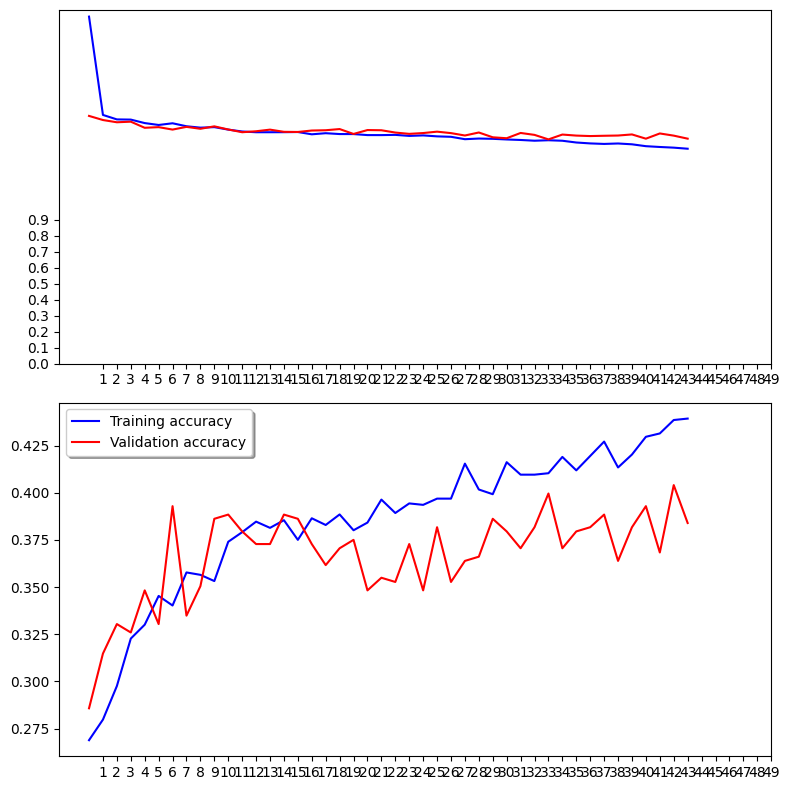

In [276]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history3.history['loss'], color='b', label="Training loss")
ax1.plot(history3.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history3.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history3.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [277]:
test_filenames2 = test2['property_id']
test_df3 = pd.DataFrame({
    'property_id': test_filenames2
})
nb_test = test_df3.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator2 = test_gen.flow_from_dataframe(
    test2, 
    "../uni_project_data/uni_project_data/sample_transparent", 
    x_col='property_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


In [278]:
predict3 = model_tran.predict_generator(test_generator2, steps=np.ceil(nb_test/batch_size))

In [279]:
predict3

array([[0.36110684, 0.15165754, 0.29263538, 0.1476632 , 0.04693701],
       [0.03759556, 0.25047615, 0.05731142, 0.5799612 , 0.07465575],
       [0.20484501, 0.2559049 , 0.33829132, 0.18732192, 0.01363693],
       ...,
       [0.43233085, 0.06370372, 0.20400906, 0.18504788, 0.11490849],
       [0.03116106, 0.17405878, 0.03736654, 0.68429846, 0.0731152 ],
       [0.09217731, 0.20209499, 0.237728  , 0.38701147, 0.08098827]],
      dtype=float32)

In [280]:
test_df3['type'] = np.argmax(predict3, axis=-1)

label_map = dict((v,k) for k,v in train_imagegenerator2.class_indices.items())
test_df3['type'] = test_df3['type'].replace(label_map)

In [281]:
df_merged_tran = pd.merge(test_df3, sample_trans[['property_id', 'propertyType']], on='property_id', how='left')
df_merged_tran

,property_id,type,propertyType
0,gsv_a428649d-a8df-4243-a897-4cdbad72ac46.png,Detached,Terraced
1,gsv_75cff80f-8ea1-4f83-8d7f-44fe9f98fb3b.png,Terraced,Terraced
2,gsv_5bee0ee5-72ce-445a-be44-886d7954f5f6.png,Semi-Detached,Flat
3,gsv_ab2ce1e0-a9f3-43cb-9657-d17f2df2f9cd.png,Detached,Detached
4,gsv_48d4b560-5af5-4332-945b-2f917be2fc72.png,Semi-Detached,Semi-Detached
...,...,...,...
495,gsv_7eec0b21-b025-4976-96df-f7110aa8418c.png,Semi-Detached,Semi-Detached
496,gsv_08871cc6-e3e7-43b2-a272-0c932c2b858b.png,Semi-Detached,Detached
497,gsv_9dd0e9e8-e484-4a68-9801-4f951b9cad50.png,Detached,Detached
498,gsv_a3e94dfa-206a-41e9-9a59-0b92d61c6c90.png,Terraced,Unknown


In [282]:
y_test3 = df_merged_tran['propertyType']
y_pred3 = df_merged_tran['type']
confusion3 = confusion_matrix(y_test3, y_pred3)
print('Confusion Matrix\n')
print(confusion3)

Confusion Matrix

[[35 14 50 12  1]
 [ 2 24 16 26  1]
 [16  5 88 19  3]
 [11 15 46 58  1]
 [ 5  8 28 14  2]]


In [283]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test3, y_pred3)))


Accuracy: 0.41



# Part5: VGG16

In [306]:
def change_extension(filename):
    return filename.replace('.png', '.jpg')

sampledf2 = sampledf
sampledf2['property_id'] = sampledf2['property_id'].apply(change_extension)

sampledf2

,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"33, Mynydd Maen Road, Pontnewydd, Cwmbran, Tor...",Terraced,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.66475,-3.03967,gsv_176edf8e-c0d2-4207-9293-c38f933f0cde.jpg
1,0,"6, Steynton Path, Fairwater, Cwmbran, Torfaen ...",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,51.64594,-3.04111,gsv_d3a04dec-6569-4bf6-8101-9e6e442b5b97.jpg
2,0,"16, Ynys Lane, Croesyceiliog, Cwmbran, Torfaen...",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.66176,-3.01054,gsv_6fe10950-4b55-434b-8ee1-52416ab82bd6.jpg
3,0,"7, Smallbrook Close, Cwmbran, Torfaen NP44 3QA",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,51.64972,-3.01981,gsv_0970de06-fb7c-4893-87db-2ac9f88433a5.jpg
4,0,"17, Dunraven Road, Llanyravon, Cwmbran, Torfae...",Semi-Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,51.64895,-3.00476,gsv_015b2b16-7dae-475f-bb40-156d817b1175.jpg
...,...,...,...,...,...,...,...,...
4995,0,"Flat 3, Aston House, Church Hill, Totland Bay,...",Flat,2.0,https://www.rightmove.co.uk/house-prices/detai...,50.67826,-1.54464,gsv_01e20c7b-fae8-429f-841a-0c1f0d00e071.jpg
4996,0,"1, Meadow Barn Close, Totland Bay, Isle Of Wig...",Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,50.67968,-1.54010,gsv_2c883a5b-4203-4152-82e8-bc6b9b8ffc9d.jpg
4997,0,"1, Dante Mews, 14a, The Avenue, Totland Bay, I...",Terraced,NaN,https://www.rightmove.co.uk/house-prices/detai...,50.68423,-1.53114,gsv_c0a72bd6-e446-470a-b8a7-ddc0ec992d0d.jpg
4998,0,"Larch Lodge, Kendal Road, Totland Bay, Isle Of...",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,50.68121,-1.53938,gsv_884f0937-15e5-4f9a-8a8c-c565b3fb2f8b.jpg


In [307]:
train4, validation4 = train_test_split(sampledf2, test_size=0.1, random_state=66)
train4, test4 = train_test_split(train4, test_size=1/9, random_state=66)

In [284]:
# Use the VGG16 model to do the image classification. 

VGGmodel = Sequential()
VGGmodel.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Flatten())
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=5, activation="softmax"))

VGGmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
VGGmodel.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_90 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_92 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                

In [285]:
IMAGE_WIDTH4=224
IMAGE_HEIGHT4=224
IMAGE_SIZE4=(IMAGE_WIDTH4, IMAGE_HEIGHT4)
IMAGE_CHANNELS=3

In [286]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    # # horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator4 = train_idg.flow_from_dataframe(
    train4, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE4,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4000 validated image filenames belonging to 5 classes.


In [287]:
validation_idg = ImageDataGenerator(rescale=1./255)
validation_imagegenerator4 = validation_idg.flow_from_dataframe(
    validation4, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE4,
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 5 classes.


In [288]:

history4 = VGGmodel.fit_generator(
    train_imagegenerator4, 
    epochs=epochs,
    validation_data=validation_imagegenerator4,
    validation_steps=validation_num//batch_size,
    steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)

Epoch 1/50
62/62 [==============================] - 1210s 19s/step - loss: 1.5761 - accuracy: 0.2571 - val_loss: 1.5494 - val_accuracy: 0.2411 - lr: 0.0010
Epoch 2/50
62/62 [==============================] - 1206s 19s/step - loss: 1.5643 - accuracy: 0.2660 - val_loss: 1.5511 - val_accuracy: 0.2879 - lr: 0.0010
Epoch 3/50
62/62 [==============================] - 1229s 20s/step - loss: 1.5619 - accuracy: 0.2670 - val_loss: 1.5490 - val_accuracy: 0.2902 - lr: 0.0010
Epoch 4/50
62/62 [==============================] - 1208s 19s/step - loss: 1.5602 - accuracy: 0.2706 - val_loss: 1.5445 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 5/50
62/62 [==============================] - 1202s 20s/step - loss: 1.5614 - accuracy: 0.2675 - val_loss: 1.5474 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 6/50
62/62 [==============================] - 1212s 20s/step - loss: 1.5620 - accuracy: 0.2652 - val_loss: 1.5516 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 7/50
62/62 [==============================] - 1400s 23s/st

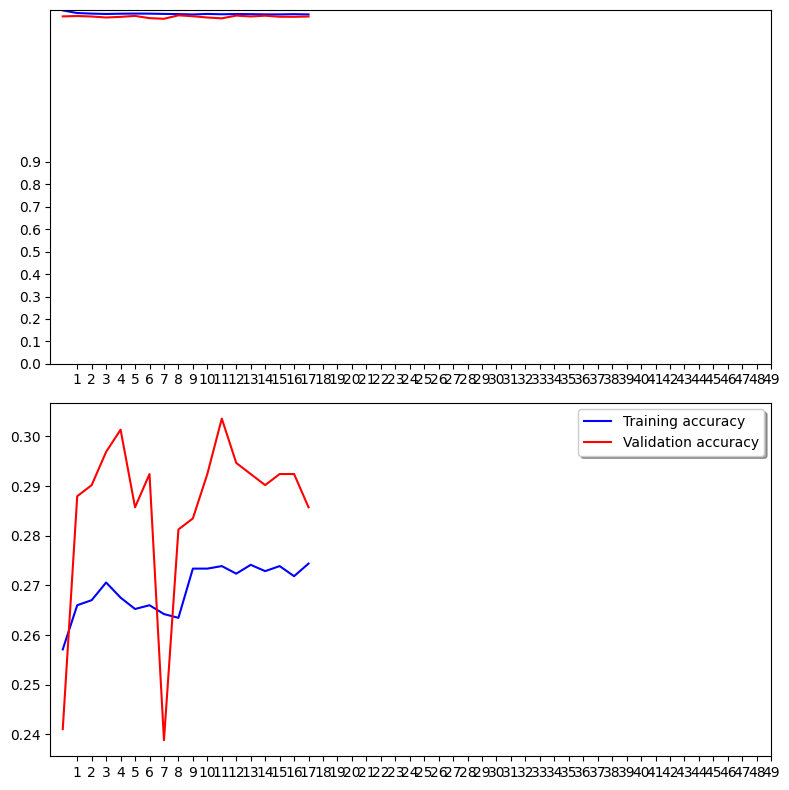

In [289]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history4.history['loss'], color='b', label="Training loss")
ax1.plot(history4.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history4.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history4.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [308]:
test_filenames = test4['property_id']
test_df4 = pd.DataFrame({
    'property_id': test_filenames
})
nb_test = test_df4.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)
test_generator4 = test_gen.flow_from_dataframe(
    test4, 
    "../uni_project_data/uni_project_data/sample5000", 
    x_col='property_id',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE4,
    batch_size=batch_size,
    shuffle=False
)



Found 500 validated image filenames.


In [309]:
predict4 = VGGmodel.predict_generator(test_generator4, steps=np.ceil(nb_test/batch_size))

In [310]:
test_df4['type'] = np.argmax(predict4, axis=-1)

label_map = dict((v,k) for k,v in train_imagegenerator4.class_indices.items())
test_df4['type'] = test_df4['type'].replace(label_map)

In [311]:
df_merged4 = pd.merge(test_df4, sampledf[['property_id', 'propertyType']], on='property_id', how='left')
df_merged4

,property_id,type,propertyType
0,gsv_a428649d-a8df-4243-a897-4cdbad72ac46.jpg,Terraced,Terraced
1,gsv_75cff80f-8ea1-4f83-8d7f-44fe9f98fb3b.jpg,Terraced,Terraced
2,gsv_5bee0ee5-72ce-445a-be44-886d7954f5f6.jpg,Terraced,Flat
3,gsv_ab2ce1e0-a9f3-43cb-9657-d17f2df2f9cd.jpg,Terraced,Detached
4,gsv_48d4b560-5af5-4332-945b-2f917be2fc72.jpg,Terraced,Semi-Detached
...,...,...,...
495,gsv_7eec0b21-b025-4976-96df-f7110aa8418c.jpg,Terraced,Semi-Detached
496,gsv_08871cc6-e3e7-43b2-a272-0c932c2b858b.jpg,Terraced,Detached
497,gsv_9dd0e9e8-e484-4a68-9801-4f951b9cad50.jpg,Terraced,Detached
498,gsv_a3e94dfa-206a-41e9-9a59-0b92d61c6c90.jpg,Terraced,Unknown


In [312]:
y_test4 = df_merged4['propertyType']
y_pred4 = df_merged4['type']
confusion4 = confusion_matrix(y_test4, y_pred4)
print('Confusion Matrix\n')
print(confusion4)

Confusion Matrix

[[  0   0   0 112   0]
 [  0   0   0  69   0]
 [  0   0   0 131   0]
 [  0   0   0 131   0]
 [  0   0   0  57   0]]


In [313]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test4, y_pred4)))


Accuracy: 0.26

